# Learning to Play SLITHER.IO with Deep Reinforcement Learning

## UE23CS352A Machine Learning Mini-Project

### Project Overview
This notebook implements a Deep Reinforcement Learning agent to play Slither.io using Deep Q-Networks (DQN). The agent learns to maximize survival time and snake length by processing raw gameplay frames.

### Problem Statement
- **Input**: Raw image frames from Slither.io gameplay
- **Output**: Action commands (left, right, straight, speed burst)
- **Objective**: Maximize survival time and snake length
- **Evaluation Metrics**: Average score, win rate vs baseline, score difference vs random policy

### Methodology
1. Environment setup and data collection
2. Frame preprocessing (crop, resize, normalize)
3. Baseline random policy implementation
4. Deep Q-Network (DQN) architecture design
5. Training with experience replay and epsilon-greedy exploration
6. Performance evaluation and comparison

### Authors
Machine Learning Course Project - 2025

# 1. Setup and Installation

First, let's install all required packages. This cell will install the necessary dependencies for our Deep RL agent.

In [1]:
# Install required packages
# Note: Since OpenAI Universe is deprecated, we'll create a simulated Slither.io environment

!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install gymnasium
!pip install numpy
!pip install matplotlib
!pip install opencv-python
!pip install pillow
!pip install imageio
!pip install tqdm

print("All packages installed successfully!")

Looking in indexes: https://download.pytorch.org/whl/cpu
All packages installed successfully!
All packages installed successfully!


# 2. Import Required Libraries

Import all necessary libraries and set random seeds for reproducibility.

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import random
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import gymnasium as gym
from gymnasium import spaces
import imageio
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")

Using device: cuda
PyTorch version: 2.5.1+cu121
NumPy version: 1.26.4


# 3. Environment Setup and Configuration

Since OpenAI Universe is deprecated, we'll create a custom Slither.io-like environment that simulates the game mechanics. The environment will have:
- **Action Space**: 4 discrete actions (left, right, straight, speed burst)
- **Observation Space**: Raw pixel frames (84x84 grayscale)
- **Rewards**: Based on survival time, food collected, and snake growth

In [3]:
class SlitherIOEnv(gym.Env):
    """
    Custom Slither.io-like environment for reinforcement learning.
    Simulates a simplified version of the game mechanics.
    """
    
    def __init__(self, grid_size=84, max_steps=1000):
        super(SlitherIOEnv, self).__init__()
        
        self.grid_size = grid_size
        self.max_steps = max_steps
        self.current_step = 0
        
        # Action space: 0=left, 1=right, 2=straight, 3=speed_burst
        self.action_space = spaces.Discrete(4)
        
        # Observation space: grayscale image
        self.observation_space = spaces.Box(
            low=0, high=255,
            shape=(grid_size, grid_size),
            dtype=np.uint8
        )
        
        # Game state
        self.snake_length = 10
        self.snake_position = [grid_size // 2, grid_size // 2]
        self.direction = 0  # 0=right, 90=up, 180=left, 270=down
        self.speed = 2
        self.food_positions = []
        self.num_food = 15
        self.score = 0
        self.alive = True
        
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        
        self.current_step = 0
        self.snake_length = 10
        self.snake_position = [self.grid_size // 2, self.grid_size // 2]
        self.direction = 0
        self.speed = 2
        self.score = 0
        self.alive = True
        
        # Generate food positions
        self.food_positions = []
        for _ in range(self.num_food):
            self.food_positions.append([
                np.random.randint(5, self.grid_size - 5),
                np.random.randint(5, self.grid_size - 5)
            ])
        
        observation = self._get_observation()
        info = {}
        
        return observation, info
    
    def step(self, action):
        self.current_step += 1
        reward = 0.01  # Small reward for survival
        
        # Update direction based on action
        if action == 0:  # Left
            self.direction = (self.direction - 30) % 360
        elif action == 1:  # Right
            self.direction = (self.direction + 30) % 360
        elif action == 2:  # Straight
            pass
        elif action == 3:  # Speed burst
            self.speed = 3
            reward -= 0.005  # Small penalty for using boost
        else:
            self.speed = 2
        
        # Move snake
        rad = np.radians(self.direction)
        self.snake_position[0] += self.speed * np.cos(rad)
        self.snake_position[1] += self.speed * np.sin(rad)
        
        # Check boundaries
        if (self.snake_position[0] < 0 or self.snake_position[0] >= self.grid_size or
            self.snake_position[1] < 0 or self.snake_position[1] >= self.grid_size):
            self.alive = False
            reward = -10  # Large penalty for dying
            done = True
            observation = self._get_observation()
            info = {'score': self.score, 'length': self.snake_length}
            return observation, reward, done, False, info
        
        # Check food collision
        for i, food_pos in enumerate(self.food_positions):
            distance = np.sqrt((self.snake_position[0] - food_pos[0])**2 + 
                             (self.snake_position[1] - food_pos[1])**2)
            if distance < 3:
                self.snake_length += 1
                self.score += 10
                reward += 5  # Reward for eating food
                # Respawn food
                self.food_positions[i] = [
                    np.random.randint(5, self.grid_size - 5),
                    np.random.randint(5, self.grid_size - 5)
                ]
        
        # Check max steps
        done = self.current_step >= self.max_steps
        if done and self.alive:
            reward += 10  # Bonus for surviving max steps
        
        observation = self._get_observation()
        info = {'score': self.score, 'length': self.snake_length}
        
        return observation, reward, done, False, info
    
    def _get_observation(self):
        """Generate the current frame observation"""
        frame = np.zeros((self.grid_size, self.grid_size), dtype=np.uint8)
        
        # Draw food
        for food_pos in self.food_positions:
            x, y = int(food_pos[0]), int(food_pos[1])
            if 0 <= x < self.grid_size and 0 <= y < self.grid_size:
                cv2.circle(frame, (x, y), 2, 150, -1)
        
        # Draw snake
        x, y = int(self.snake_position[0]), int(self.snake_position[1])
        if 0 <= x < self.grid_size and 0 <= y < self.grid_size:
            length = min(int(self.snake_length / 2), 10)
            cv2.circle(frame, (x, y), length, 255, -1)
            
            # Draw direction indicator
            rad = np.radians(self.direction)
            end_x = int(x + 15 * np.cos(rad))
            end_y = int(y + 15 * np.sin(rad))
            cv2.line(frame, (x, y), (end_x, end_y), 200, 2)
        
        return frame
    
    def render(self, mode='rgb_array'):
        frame = self._get_observation()
        # Convert to RGB for visualization
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
        return rgb_frame

# Test the environment
env = SlitherIOEnv()
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")

# Test reset and step
obs, info = env.reset()
print(f"Initial observation shape: {obs.shape}")
obs, reward, done, truncated, info = env.step(2)
print(f"Step reward: {reward}, Done: {done}, Info: {info}")
print("Environment created successfully!")

Action space: Discrete(4)
Observation space: Box(0, 255, (84, 84), uint8)
Initial observation shape: (84, 84)
Step reward: 0.01, Done: False, Info: {'score': 0, 'length': 10}
Environment created successfully!


# 4. Data Collection and Preprocessing

Let's visualize some sample frames from the environment to understand what our agent will see.

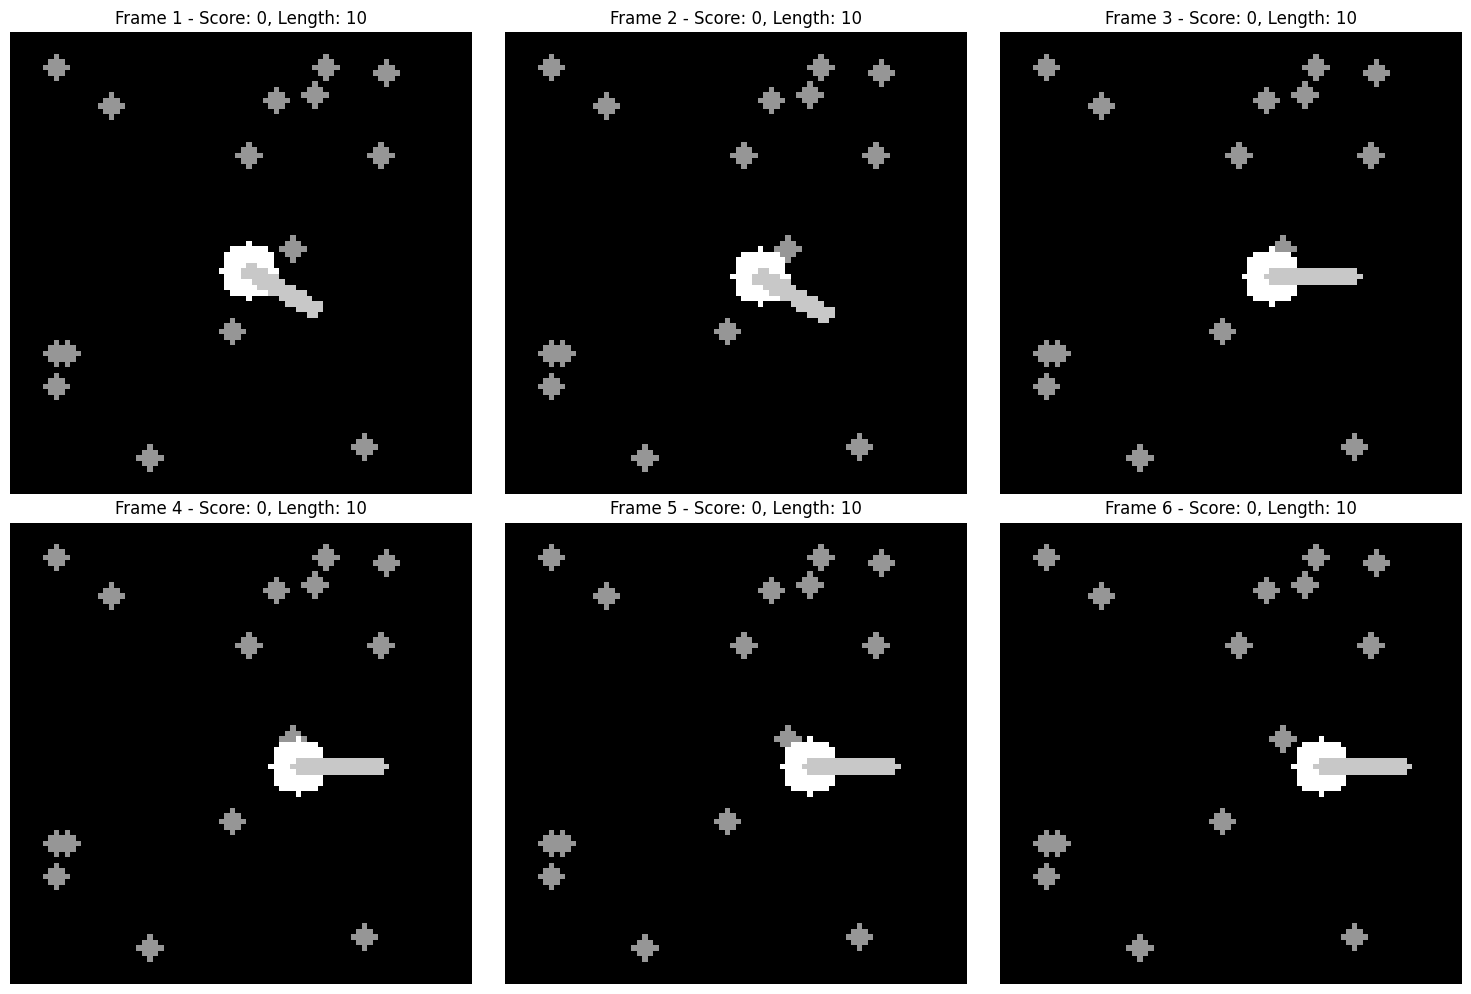

Collected 6 sample frames
Frame shape: (84, 84)
Frame dtype: uint8


In [4]:
# Collect and visualize sample frames
env = SlitherIOEnv()
obs, info = env.reset()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
frames = []

for i in range(6):
    # Take random actions
    action = env.action_space.sample()
    obs, reward, done, truncated, info = env.step(action)
    frames.append(obs)
    
    ax = axes[i // 3, i % 3]
    ax.imshow(obs, cmap='gray')
    ax.set_title(f'Frame {i+1} - Score: {info["score"]}, Length: {info["length"]}')
    ax.axis('off')
    
    if done:
        break

plt.tight_layout()
plt.savefig('sample_frames.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Collected {len(frames)} sample frames")
print(f"Frame shape: {frames[0].shape}")
print(f"Frame dtype: {frames[0].dtype}")

# 5. Frame Preprocessing Pipeline

Implement preprocessing functions to prepare frames for the neural network:
- Normalization to [0, 1] range
- Frame stacking (4 consecutive frames) for temporal information
- Frame skipping to reduce computational cost

Original frame shape: (84, 84)
Preprocessed state shape: (4, 84, 84)
State dtype: float32
State range: [0.00, 1.00]


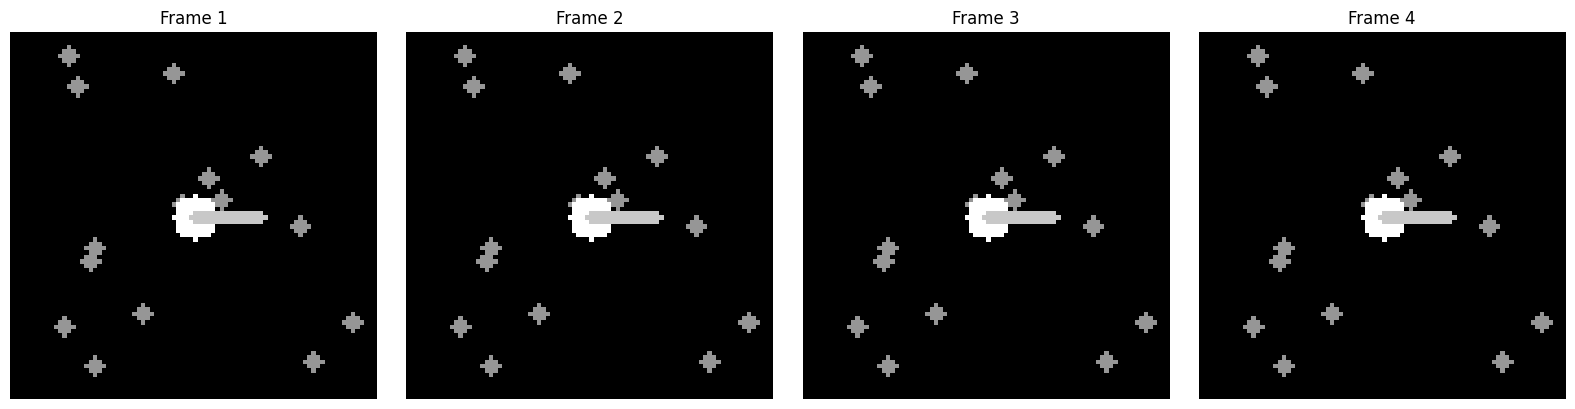

In [5]:
class FramePreprocessor:
    """Preprocesses frames for neural network input"""
    
    def __init__(self, frame_stack=4):
        self.frame_stack = frame_stack
        self.frames = deque(maxlen=frame_stack)
    
    def reset(self):
        """Clear the frame buffer"""
        self.frames.clear()
    
    def preprocess_frame(self, frame):
        """
        Preprocess a single frame:
        - Normalize to [0, 1]
        - Convert to float32
        """
        # Normalize
        frame = frame.astype(np.float32) / 255.0
        return frame
    
    def add_frame(self, frame):
        """Add a frame to the stack"""
        processed = self.preprocess_frame(frame)
        self.frames.append(processed)
        
        # If we don't have enough frames yet, repeat the current frame
        while len(self.frames) < self.frame_stack:
            self.frames.append(processed)
    
    def get_state(self):
        """Get the current stacked state"""
        # Stack frames along channel dimension
        stacked = np.stack(self.frames, axis=0)  # Shape: (4, 84, 84)
        return stacked

# Test the preprocessor
preprocessor = FramePreprocessor(frame_stack=4)
env = SlitherIOEnv()
obs, info = env.reset()

preprocessor.reset()
preprocessor.add_frame(obs)
state = preprocessor.get_state()

print(f"Original frame shape: {obs.shape}")
print(f"Preprocessed state shape: {state.shape}")
print(f"State dtype: {state.dtype}")
print(f"State range: [{state.min():.2f}, {state.max():.2f}]")

# Visualize stacked frames
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    axes[i].imshow(state[i], cmap='gray')
    axes[i].set_title(f'Frame {i+1}')
    axes[i].axis('off')
plt.tight_layout()
plt.savefig('stacked_frames.png', dpi=150, bbox_inches='tight')
plt.show()

# 6. Replay Buffer Implementation

Implement an experience replay buffer to store and sample transitions for training the DQN.

In [6]:
# Define transition tuple
Transition = namedtuple('Transition', 
                       ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    """Experience replay buffer for DQN training"""
    
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        """Add a transition to the buffer"""
        self.buffer.append(Transition(state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        """Sample a batch of transitions"""
        transitions = random.sample(self.buffer, batch_size)
        
        # Transpose the batch
        batch = Transition(*zip(*transitions))
        
        # Convert to numpy arrays
        states = np.array(batch.state)
        actions = np.array(batch.action)
        rewards = np.array(batch.reward)
        next_states = np.array(batch.next_state)
        dones = np.array(batch.done)
        
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.buffer)

# Test the replay buffer
replay_buffer = ReplayBuffer(capacity=1000)

# Add some dummy transitions
preprocessor = FramePreprocessor()
env = SlitherIOEnv()
obs, info = env.reset()
preprocessor.reset()
preprocessor.add_frame(obs)
state = preprocessor.get_state()

for _ in range(10):
    action = env.action_space.sample()
    next_obs, reward, done, truncated, info = env.step(action)
    preprocessor.add_frame(next_obs)
    next_state = preprocessor.get_state()
    
    replay_buffer.push(state, action, reward, next_state, done)
    state = next_state
    
    if done:
        break

print(f"Replay buffer size: {len(replay_buffer)}")

# Test sampling
if len(replay_buffer) >= 4:
    states, actions, rewards, next_states, dones = replay_buffer.sample(4)
    print(f"Sample batch - States shape: {states.shape}")
    print(f"Sample batch - Actions shape: {actions.shape}")
    print(f"Sample batch - Rewards: {rewards}")
    print(f"Sample batch - Dones: {dones}")
    
print("Replay buffer implemented successfully!")

Replay buffer size: 10
Sample batch - States shape: (4, 4, 84, 84)
Sample batch - Actions shape: (4,)
Sample batch - Rewards: [0.01  0.005 0.01  0.01 ]
Sample batch - Dones: [False False False False]
Replay buffer implemented successfully!


# 7. Baseline Policy Implementation

Implement a random policy as a baseline for comparison. This will help us measure the improvement of our trained DQN agent.

Evaluating random policy baseline...

=== Random Policy Baseline Results ===
Average Score: 9.20 ± 8.68
Average Length: 10.92 ± 0.87
Average Survival Time: 22.84 ± 6.82
Max Score: 30.00
Min Score: 0.00


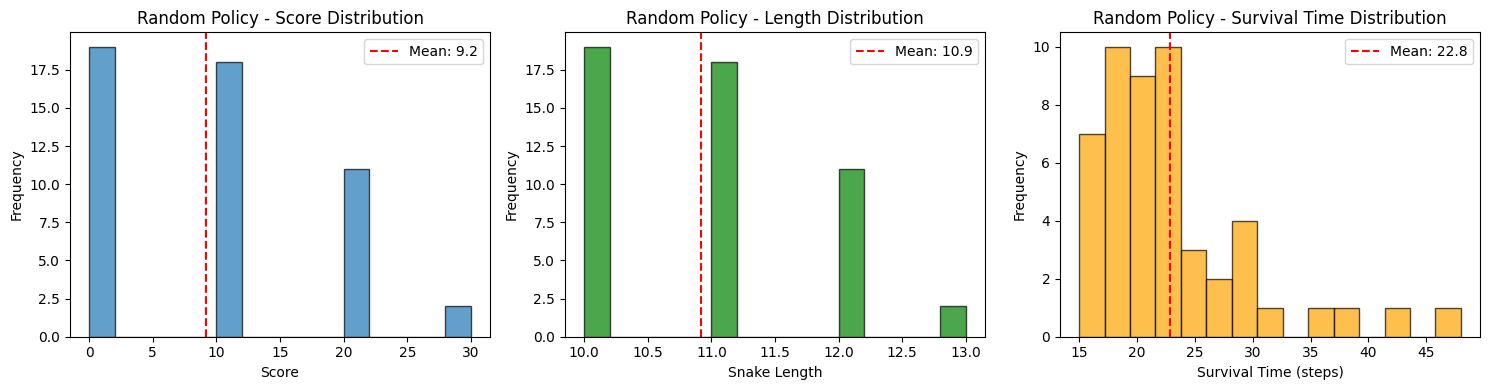

In [7]:
def evaluate_random_policy(env, num_episodes=20):
    """
    Evaluate a random policy on the environment
    Returns: scores, lengths, survival_times
    """
    scores = []
    lengths = []
    survival_times = []
    
    for episode in range(num_episodes):
        obs, info = env.reset()
        done = False
        steps = 0
        
        while not done:
            action = env.action_space.sample()  # Random action
            obs, reward, done, truncated, info = env.step(action)
            steps += 1
            
            if done or truncated:
                break
        
        scores.append(info['score'])
        lengths.append(info['length'])
        survival_times.append(steps)
    
    return scores, lengths, survival_times

# Evaluate random policy
print("Evaluating random policy baseline...")
env = SlitherIOEnv(max_steps=500)
random_scores, random_lengths, random_survival = evaluate_random_policy(env, num_episodes=50)

print(f"\n=== Random Policy Baseline Results ===")
print(f"Average Score: {np.mean(random_scores):.2f} ± {np.std(random_scores):.2f}")
print(f"Average Length: {np.mean(random_lengths):.2f} ± {np.std(random_lengths):.2f}")
print(f"Average Survival Time: {np.mean(random_survival):.2f} ± {np.std(random_survival):.2f}")
print(f"Max Score: {np.max(random_scores):.2f}")
print(f"Min Score: {np.min(random_scores):.2f}")

# Plot baseline performance
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(random_scores, bins=15, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Random Policy - Score Distribution')
axes[0].axvline(np.mean(random_scores), color='red', linestyle='--', label=f'Mean: {np.mean(random_scores):.1f}')
axes[0].legend()

axes[1].hist(random_lengths, bins=15, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Snake Length')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Random Policy - Length Distribution')
axes[1].axvline(np.mean(random_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(random_lengths):.1f}')
axes[1].legend()

axes[2].hist(random_survival, bins=15, edgecolor='black', alpha=0.7, color='orange')
axes[2].set_xlabel('Survival Time (steps)')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Random Policy - Survival Time Distribution')
axes[2].axvline(np.mean(random_survival), color='red', linestyle='--', label=f'Mean: {np.mean(random_survival):.1f}')
axes[2].legend()

plt.tight_layout()
plt.savefig('baseline_performance.png', dpi=150, bbox_inches='tight')
plt.show()

# 8. DQN Model Architecture

Implement the Deep Q-Network with convolutional layers for processing stacked frames. The architecture includes:
- 3 Convolutional layers for feature extraction
- Fully connected layers for Q-value estimation
- Separate online and target networks

In [8]:
class DQN(nn.Module):
    """
    Deep Q-Network with convolutional layers
    Input: Stacked frames (4, 84, 84)
    Output: Q-values for each action
    """
    
    def __init__(self, input_channels=4, num_actions=4):
        super(DQN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        # Calculate size after convolutions
        # Input: 84x84
        # After conv1 (8x8, stride 4): (84-8)/4+1 = 20
        # After conv2 (4x4, stride 2): (20-4)/2+1 = 9
        # After conv3 (3x3, stride 1): (9-3)/1+1 = 7
        # Final feature map: 64 channels * 7 * 7 = 3136
        
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, num_actions)
    
    def forward(self, x):
        """Forward pass through the network"""
        # Convolutional layers with ReLU activation
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

# Test the DQN model
test_model = DQN(input_channels=4, num_actions=4).to(device)
print(test_model)

# Test forward pass
test_input = torch.randn(1, 4, 84, 84).to(device)  # Batch size 1
test_output = test_model(test_input)
print(f"\nInput shape: {test_input.shape}")
print(f"Output shape: {test_output.shape}")
print(f"Output (Q-values): {test_output.detach().cpu().numpy()}")

# Count parameters
total_params = sum(p.numel() for p in test_model.parameters())
trainable_params = sum(p.numel() for p in test_model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

print("\nDQN model created successfully!")

DQN(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)

Input shape: torch.Size([1, 4, 84, 84])
Output shape: torch.Size([1, 4])
Output (Q-values): [[ 0.03090759 -0.02443604  0.01952279 -0.02791374]]

Total parameters: 1,686,180
Trainable parameters: 1,686,180

DQN model created successfully!

Input shape: torch.Size([1, 4, 84, 84])
Output shape: torch.Size([1, 4])
Output (Q-values): [[ 0.03090759 -0.02443604  0.01952279 -0.02791374]]

Total parameters: 1,686,180
Trainable parameters: 1,686,180

DQN model created successfully!


# 9. Training Configuration and Hyperparameters

Define all hyperparameters for DQN training including learning rate, discount factor, exploration parameters, and training schedule.

In [9]:
# Hyperparameters
HYPERPARAMETERS = {
    # Environment
    'max_steps_per_episode': 500,
    'frame_stack': 4,
    
    # Training
    'num_episodes': 300,  # Total training episodes
    'batch_size': 32,
    'learning_rate': 0.00025,
    'gamma': 0.99,  # Discount factor
    
    # Exploration
    'epsilon_start': 1.0,
    'epsilon_end': 0.01,
    'epsilon_decay': 0.995,
    
    # Replay buffer
    'replay_buffer_size': 10000,
    'min_replay_size': 1000,  # Start training after this many transitions
    
    # Target network
    'target_update_frequency': 10,  # Update target network every N episodes
    
    # Evaluation
    'eval_frequency': 20,  # Evaluate every N episodes
    'eval_episodes': 10,
}

# Print hyperparameters
print("=== DQN Training Hyperparameters ===")
for key, value in HYPERPARAMETERS.items():
    print(f"{key:30s}: {value}")
    
# Calculate total training steps (approximate)
total_steps = HYPERPARAMETERS['num_episodes'] * HYPERPARAMETERS['max_steps_per_episode']
print(f"\n{'Approximate total steps':30s}: {total_steps:,}")

=== DQN Training Hyperparameters ===
max_steps_per_episode         : 500
frame_stack                   : 4
num_episodes                  : 300
batch_size                    : 32
learning_rate                 : 0.00025
gamma                         : 0.99
epsilon_start                 : 1.0
epsilon_end                   : 0.01
epsilon_decay                 : 0.995
replay_buffer_size            : 10000
min_replay_size               : 1000
target_update_frequency       : 10
eval_frequency                : 20
eval_episodes                 : 10

Approximate total steps       : 150,000


# 10. Training Loop Implementation

Implement the complete DQN training loop with:
- Epsilon-greedy exploration
- Experience replay
- Target network updates
- Loss computation using Temporal Difference (TD) error

In [10]:
class DQNAgent:
    """DQN Agent for training and evaluation"""
    
    def __init__(self, hyperparameters):
        self.hp = hyperparameters
        
        # Networks
        self.policy_net = DQN(input_channels=self.hp['frame_stack'], num_actions=4).to(device)
        self.target_net = DQN(input_channels=self.hp['frame_stack'], num_actions=4).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        # Optimizer
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.hp['learning_rate'])
        
        # Replay buffer
        self.replay_buffer = ReplayBuffer(capacity=self.hp['replay_buffer_size'])
        
        # Exploration
        self.epsilon = self.hp['epsilon_start']
        
        # Tracking
        self.training_step = 0
        
    def select_action(self, state, evaluation=False):
        """Select action using epsilon-greedy policy"""
        if evaluation or random.random() > self.epsilon:
            # Exploitation: choose best action
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = self.policy_net(state_tensor)
                action = q_values.argmax(dim=1).item()
        else:
            # Exploration: random action
            action = random.randrange(4)
        
        return action
    
    def update_epsilon(self):
        """Decay epsilon"""
        self.epsilon = max(self.hp['epsilon_end'], 
                          self.epsilon * self.hp['epsilon_decay'])
    
    def train_step(self):
        """Perform one training step"""
        if len(self.replay_buffer) < self.hp['min_replay_size']:
            return None
        
        # Sample batch
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(
            self.hp['batch_size']
        )
        
        # Convert to tensors
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)
        
        # Current Q-values
        current_q_values = self.policy_net(states).gather(1, actions.unsqueeze(1))
        
        # Next Q-values from target network
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.hp['gamma'] * next_q_values
        
        # Compute loss (Huber loss is more stable than MSE)
        loss = F.smooth_l1_loss(current_q_values.squeeze(), target_q_values)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()
        
        self.training_step += 1
        
        return loss.item()
    
    def update_target_network(self):
        """Copy weights from policy network to target network"""
        self.target_net.load_state_dict(self.policy_net.state_dict())

# Initialize agent
agent = DQNAgent(HYPERPARAMETERS)
print(f"DQN Agent initialized")
print(f"Policy network parameters: {sum(p.numel() for p in agent.policy_net.parameters()):,}")
print(f"Initial epsilon: {agent.epsilon}")

DQN Agent initialized
Policy network parameters: 1,686,180
Initial epsilon: 1.0


### Main Training Loop

Now let's run the complete training loop!

In [11]:
def train_dqn(agent, env, hyperparameters):
    """Main training loop for DQN"""
    
    # Tracking metrics
    episode_rewards = []
    episode_scores = []
    episode_lengths = []
    episode_steps = []
    losses = []
    epsilons = []
    
    # Evaluation metrics
    eval_episodes_list = []
    eval_scores = []
    eval_lengths = []
    
    # Frame preprocessor
    preprocessor = FramePreprocessor(frame_stack=hyperparameters['frame_stack'])
    
    print("Starting training...")
    print(f"Training for {hyperparameters['num_episodes']} episodes")
    print(f"Replay buffer will start training after {hyperparameters['min_replay_size']} samples\n")
    
    for episode in tqdm(range(hyperparameters['num_episodes']), desc="Training"):
        # Reset environment
        obs, info = env.reset()
        preprocessor.reset()
        preprocessor.add_frame(obs)
        state = preprocessor.get_state()
        
        episode_reward = 0
        episode_loss = []
        steps = 0
        done = False
        
        while not done:
            # Select action
            action = agent.select_action(state)
            
            # Take action
            next_obs, reward, done, truncated, info = env.step(action)
            preprocessor.add_frame(next_obs)
            next_state = preprocessor.get_state()
            
            # Store transition
            agent.replay_buffer.push(state, action, reward, next_state, done or truncated)
            
            # Train
            loss = agent.train_step()
            if loss is not None:
                episode_loss.append(loss)
            
            episode_reward += reward
            state = next_state
            steps += 1
            
            if done or truncated:
                break
        
        # Update epsilon
        agent.update_epsilon()
        
        # Update target network
        if (episode + 1) % hyperparameters['target_update_frequency'] == 0:
            agent.update_target_network()
        
        # Track metrics
        episode_rewards.append(episode_reward)
        episode_scores.append(info['score'])
        episode_lengths.append(info['length'])
        episode_steps.append(steps)
        epsilons.append(agent.epsilon)
        
        if episode_loss:
            losses.append(np.mean(episode_loss))
        else:
            losses.append(0)
        
        # Evaluation
        if (episode + 1) % hyperparameters['eval_frequency'] == 0:
            eval_score, eval_length = evaluate_agent(agent, env, 
                                                     num_episodes=hyperparameters['eval_episodes'],
                                                     preprocessor_class=FramePreprocessor)
            eval_episodes_list.append(episode + 1)
            eval_scores.append(eval_score)
            eval_lengths.append(eval_length)
            
            print(f"\nEpisode {episode + 1}/{hyperparameters['num_episodes']}")
            print(f"  Avg Reward (last 10): {np.mean(episode_rewards[-10:]):.2f}")
            print(f"  Avg Score (last 10): {np.mean(episode_scores[-10:]):.2f}")
            print(f"  Eval Score: {eval_score:.2f}")
            print(f"  Epsilon: {agent.epsilon:.3f}")
            print(f"  Replay Buffer Size: {len(agent.replay_buffer)}")
    
    print("\nTraining completed!")
    
    # Return all metrics
    return {
        'episode_rewards': episode_rewards,
        'episode_scores': episode_scores,
        'episode_lengths': episode_lengths,
        'episode_steps': episode_steps,
        'losses': losses,
        'epsilons': epsilons,
        'eval_episodes': eval_episodes_list,
        'eval_scores': eval_scores,
        'eval_lengths': eval_lengths,
    }

def evaluate_agent(agent, env, num_episodes=10, preprocessor_class=FramePreprocessor):
    """Evaluate the agent without exploration"""
    scores = []
    lengths = []
    
    preprocessor = preprocessor_class(frame_stack=4)
    
    for _ in range(num_episodes):
        obs, info = env.reset()
        preprocessor.reset()
        preprocessor.add_frame(obs)
        state = preprocessor.get_state()
        
        done = False
        
        while not done:
            action = agent.select_action(state, evaluation=True)
            obs, reward, done, truncated, info = env.step(action)
            preprocessor.add_frame(obs)
            state = preprocessor.get_state()
            
            if done or truncated:
                break
        
        scores.append(info['score'])
        lengths.append(info['length'])
    
    return np.mean(scores), np.mean(lengths)

# Create environment and agent
env = SlitherIOEnv(max_steps=HYPERPARAMETERS['max_steps_per_episode'])
agent = DQNAgent(HYPERPARAMETERS)

# Train the agent
training_metrics = train_dqn(agent, env, HYPERPARAMETERS)

Starting training...
Training for 300 episodes
Replay buffer will start training after 1000 samples



Training:  12%|█▏        | 35/300 [00:00<00:04, 53.99it/s] 


Episode 20/300
  Avg Reward (last 10): -6.82
  Avg Score (last 10): 6.00
  Eval Score: 6.00
  Epsilon: 0.905
  Replay Buffer Size: 434


Training:  15%|█▌        | 45/300 [00:00<00:05, 46.84it/s]


Episode 40/300
  Avg Reward (last 10): -8.85
  Avg Score (last 10): 2.00
  Eval Score: 3.00
  Epsilon: 0.818
  Replay Buffer Size: 827


Training:  20%|██        | 60/300 [00:05<00:43,  5.51it/s]


Episode 60/300
  Avg Reward (last 10): -4.32
  Avg Score (last 10): 11.00
  Eval Score: 11.00
  Epsilon: 0.740
  Replay Buffer Size: 1227


Training:  27%|██▋       | 80/300 [00:14<04:26,  1.21s/it]


Episode 80/300
  Avg Reward (last 10): -4.31
  Avg Score (last 10): 11.00
  Eval Score: 23.00
  Epsilon: 0.670
  Replay Buffer Size: 1769


Training:  33%|███▎      | 100/300 [00:20<01:17,  2.58it/s]


Episode 100/300
  Avg Reward (last 10): -2.31
  Avg Score (last 10): 15.00
  Eval Score: 11.00
  Epsilon: 0.606
  Replay Buffer Size: 2253


Training:  40%|████      | 120/300 [00:27<02:43,  1.10it/s]


Episode 120/300
  Avg Reward (last 10): -6.82
  Avg Score (last 10): 6.00
  Eval Score: 27.00
  Epsilon: 0.548
  Replay Buffer Size: 2756


Training:  47%|████▋     | 140/300 [00:33<01:03,  2.51it/s]


Episode 140/300
  Avg Reward (last 10): -1.28
  Avg Score (last 10): 17.00
  Eval Score: 12.00
  Epsilon: 0.496
  Replay Buffer Size: 3308


Training:  53%|█████▎    | 160/300 [00:39<01:15,  1.86it/s]


Episode 160/300
  Avg Reward (last 10): -2.30
  Avg Score (last 10): 15.00
  Eval Score: 31.00
  Epsilon: 0.448
  Replay Buffer Size: 3863


Training:  60%|██████    | 180/300 [00:45<00:47,  2.51it/s]


Episode 180/300
  Avg Reward (last 10): -4.74
  Avg Score (last 10): 10.00
  Eval Score: 11.00
  Epsilon: 0.406
  Replay Buffer Size: 4415


Training:  67%|██████▋   | 200/300 [00:52<00:58,  1.70it/s]


Episode 200/300
  Avg Reward (last 10): 2.31
  Avg Score (last 10): 24.00
  Eval Score: 20.00
  Epsilon: 0.367
  Replay Buffer Size: 5058


Training:  73%|███████▎  | 220/300 [01:00<00:47,  1.69it/s]


Episode 220/300
  Avg Reward (last 10): -0.22
  Avg Score (last 10): 19.00
  Eval Score: 21.00
  Epsilon: 0.332
  Replay Buffer Size: 5810


Training:  80%|████████  | 240/300 [01:11<00:33,  1.78it/s]


Episode 240/300
  Avg Reward (last 10): -1.55
  Avg Score (last 10): 16.00
  Eval Score: 24.00
  Epsilon: 0.300
  Replay Buffer Size: 6789


Training:  87%|████████▋ | 260/300 [01:23<00:34,  1.17it/s]


Episode 260/300
  Avg Reward (last 10): -1.62
  Avg Score (last 10): 16.00
  Eval Score: 21.00
  Epsilon: 0.272
  Replay Buffer Size: 7872


Training:  93%|█████████▎| 280/300 [01:35<00:13,  1.44it/s]


Episode 280/300
  Avg Reward (last 10): -1.03
  Avg Score (last 10): 17.00
  Eval Score: 28.00
  Epsilon: 0.246
  Replay Buffer Size: 8975


Training: 100%|██████████| 300/300 [01:50<00:00,  2.71it/s]


Episode 300/300
  Avg Reward (last 10): 3.98
  Avg Score (last 10): 27.00
  Eval Score: 38.00
  Epsilon: 0.222
  Replay Buffer Size: 10000

Training completed!


# 11. Training Metrics Visualization

Visualize the training progress including rewards, scores, loss curves, and epsilon decay.

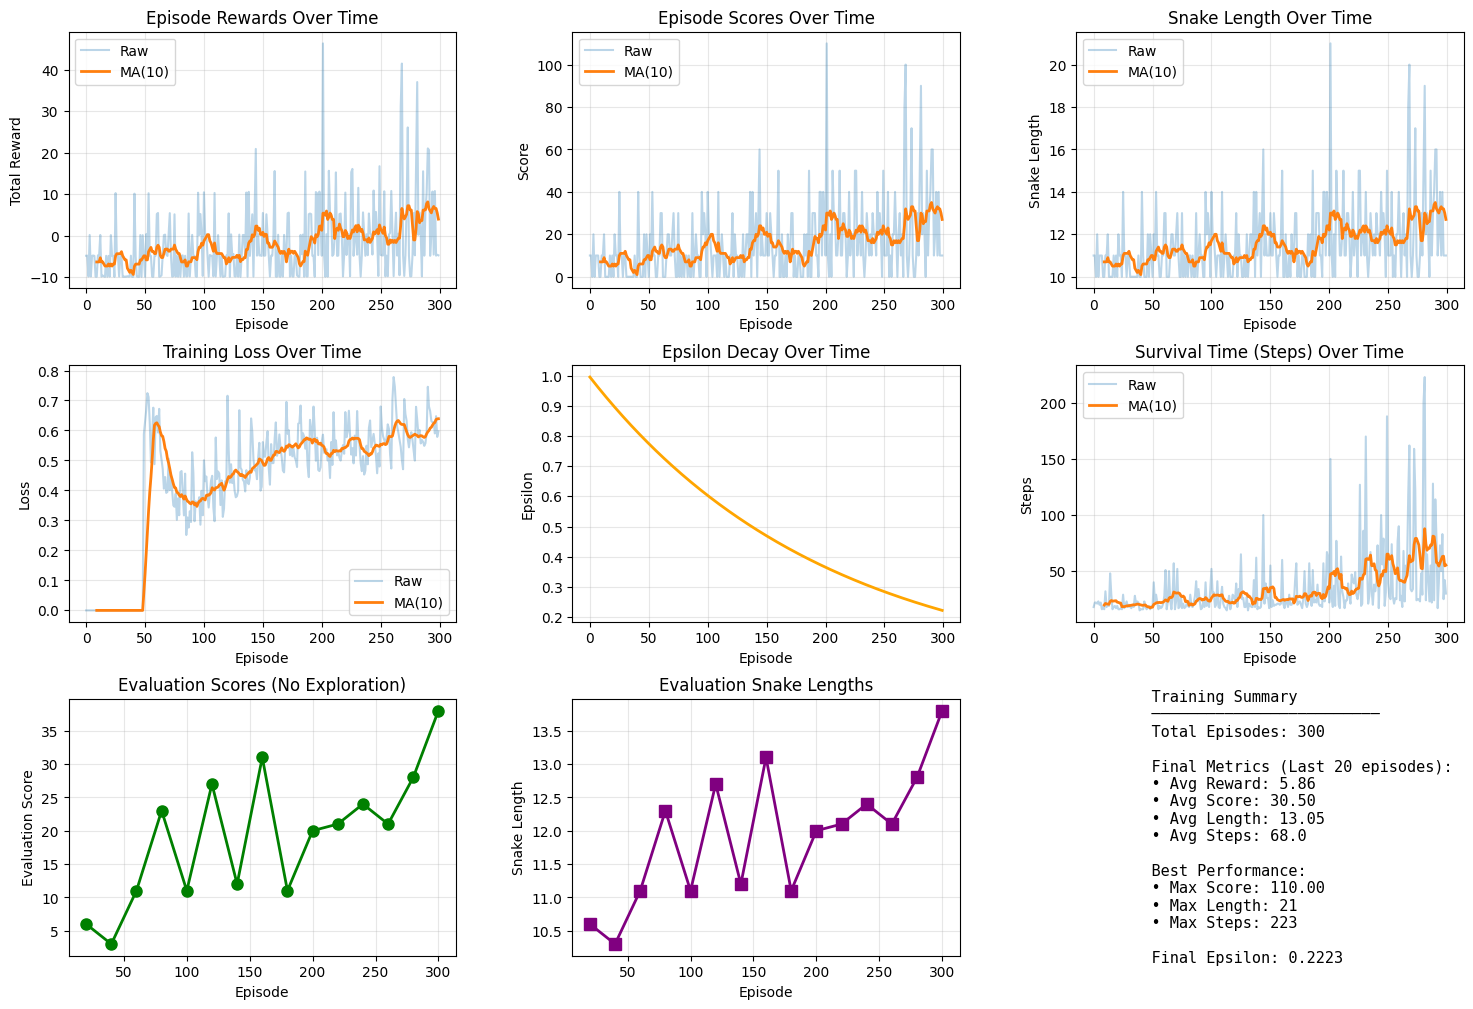

In [12]:
def plot_training_metrics(metrics, window=10):
    """Plot comprehensive training metrics"""
    
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Moving average helper
    def moving_average(data, window):
        if len(data) < window:
            return data
        return np.convolve(data, np.ones(window)/window, mode='valid')
    
    # 1. Episode Rewards
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(metrics['episode_rewards'], alpha=0.3, label='Raw')
    if len(metrics['episode_rewards']) >= window:
        ma_rewards = moving_average(metrics['episode_rewards'], window)
        ax1.plot(range(window-1, len(metrics['episode_rewards'])), ma_rewards, 
                linewidth=2, label=f'MA({window})')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.set_title('Episode Rewards Over Time')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Episode Scores
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(metrics['episode_scores'], alpha=0.3, label='Raw')
    if len(metrics['episode_scores']) >= window:
        ma_scores = moving_average(metrics['episode_scores'], window)
        ax2.plot(range(window-1, len(metrics['episode_scores'])), ma_scores, 
                linewidth=2, label=f'MA({window})')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Score')
    ax2.set_title('Episode Scores Over Time')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Episode Lengths (Snake Length)
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(metrics['episode_lengths'], alpha=0.3, label='Raw')
    if len(metrics['episode_lengths']) >= window:
        ma_lengths = moving_average(metrics['episode_lengths'], window)
        ax3.plot(range(window-1, len(metrics['episode_lengths'])), ma_lengths, 
                linewidth=2, label=f'MA({window})')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Snake Length')
    ax3.set_title('Snake Length Over Time')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Loss
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.plot(metrics['losses'], alpha=0.3, label='Raw')
    if len(metrics['losses']) >= window:
        ma_loss = moving_average(metrics['losses'], window)
        ax4.plot(range(window-1, len(metrics['losses'])), ma_loss, 
                linewidth=2, label=f'MA({window})')
    ax4.set_xlabel('Episode')
    ax4.set_ylabel('Loss')
    ax4.set_title('Training Loss Over Time')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Epsilon
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.plot(metrics['epsilons'], linewidth=2, color='orange')
    ax5.set_xlabel('Episode')
    ax5.set_ylabel('Epsilon')
    ax5.set_title('Epsilon Decay Over Time')
    ax5.grid(True, alpha=0.3)
    
    # 6. Survival Steps
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.plot(metrics['episode_steps'], alpha=0.3, label='Raw')
    if len(metrics['episode_steps']) >= window:
        ma_steps = moving_average(metrics['episode_steps'], window)
        ax6.plot(range(window-1, len(metrics['episode_steps'])), ma_steps, 
                linewidth=2, label=f'MA({window})')
    ax6.set_xlabel('Episode')
    ax6.set_ylabel('Steps')
    ax6.set_title('Survival Time (Steps) Over Time')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    # 7. Evaluation Scores
    ax7 = fig.add_subplot(gs[2, 0])
    if metrics['eval_scores']:
        ax7.plot(metrics['eval_episodes'], metrics['eval_scores'], 
                marker='o', linewidth=2, markersize=8, color='green')
        ax7.set_xlabel('Episode')
        ax7.set_ylabel('Evaluation Score')
        ax7.set_title('Evaluation Scores (No Exploration)')
        ax7.grid(True, alpha=0.3)
    
    # 8. Evaluation Lengths
    ax8 = fig.add_subplot(gs[2, 1])
    if metrics['eval_lengths']:
        ax8.plot(metrics['eval_episodes'], metrics['eval_lengths'], 
                marker='s', linewidth=2, markersize=8, color='purple')
        ax8.set_xlabel('Episode')
        ax8.set_ylabel('Snake Length')
        ax8.set_title('Evaluation Snake Lengths')
        ax8.grid(True, alpha=0.3)
    
    # 9. Summary Statistics
    ax9 = fig.add_subplot(gs[2, 2])
    ax9.axis('off')
    
    summary_text = f"""
    Training Summary
    ─────────────────────────
    Total Episodes: {len(metrics['episode_rewards'])}
    
    Final Metrics (Last 20 episodes):
    • Avg Reward: {np.mean(metrics['episode_rewards'][-20:]):.2f}
    • Avg Score: {np.mean(metrics['episode_scores'][-20:]):.2f}
    • Avg Length: {np.mean(metrics['episode_lengths'][-20:]):.2f}
    • Avg Steps: {np.mean(metrics['episode_steps'][-20:]):.1f}
    
    Best Performance:
    • Max Score: {np.max(metrics['episode_scores']):.2f}
    • Max Length: {np.max(metrics['episode_lengths']):.0f}
    • Max Steps: {np.max(metrics['episode_steps']):.0f}
    
    Final Epsilon: {metrics['epsilons'][-1]:.4f}
    """
    
    ax9.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
            verticalalignment='center')
    
    plt.savefig('training_metrics.png', dpi=150, bbox_inches='tight')
    plt.show()

# Plot all training metrics
plot_training_metrics(training_metrics, window=10)

# 12. Model Evaluation

Evaluate the trained DQN agent on multiple test episodes to assess its performance.


EVALUATING TRAINED DQN AGENT
Evaluating trained DQN agent for 50 episodes...


Evaluating: 100%|██████████| 50/50 [00:07<00:00,  6.33it/s]




=== Trained DQN Agent Results ===
Average Score: 26.40 ± 21.98
Average Length: 12.64 ± 2.20
Average Survival Time: 150.78 ± 180.85
Average Total Reward: 8.53 ± 15.07
Max Score: 90.00
Max Length: 19
Max Survival Time: 500


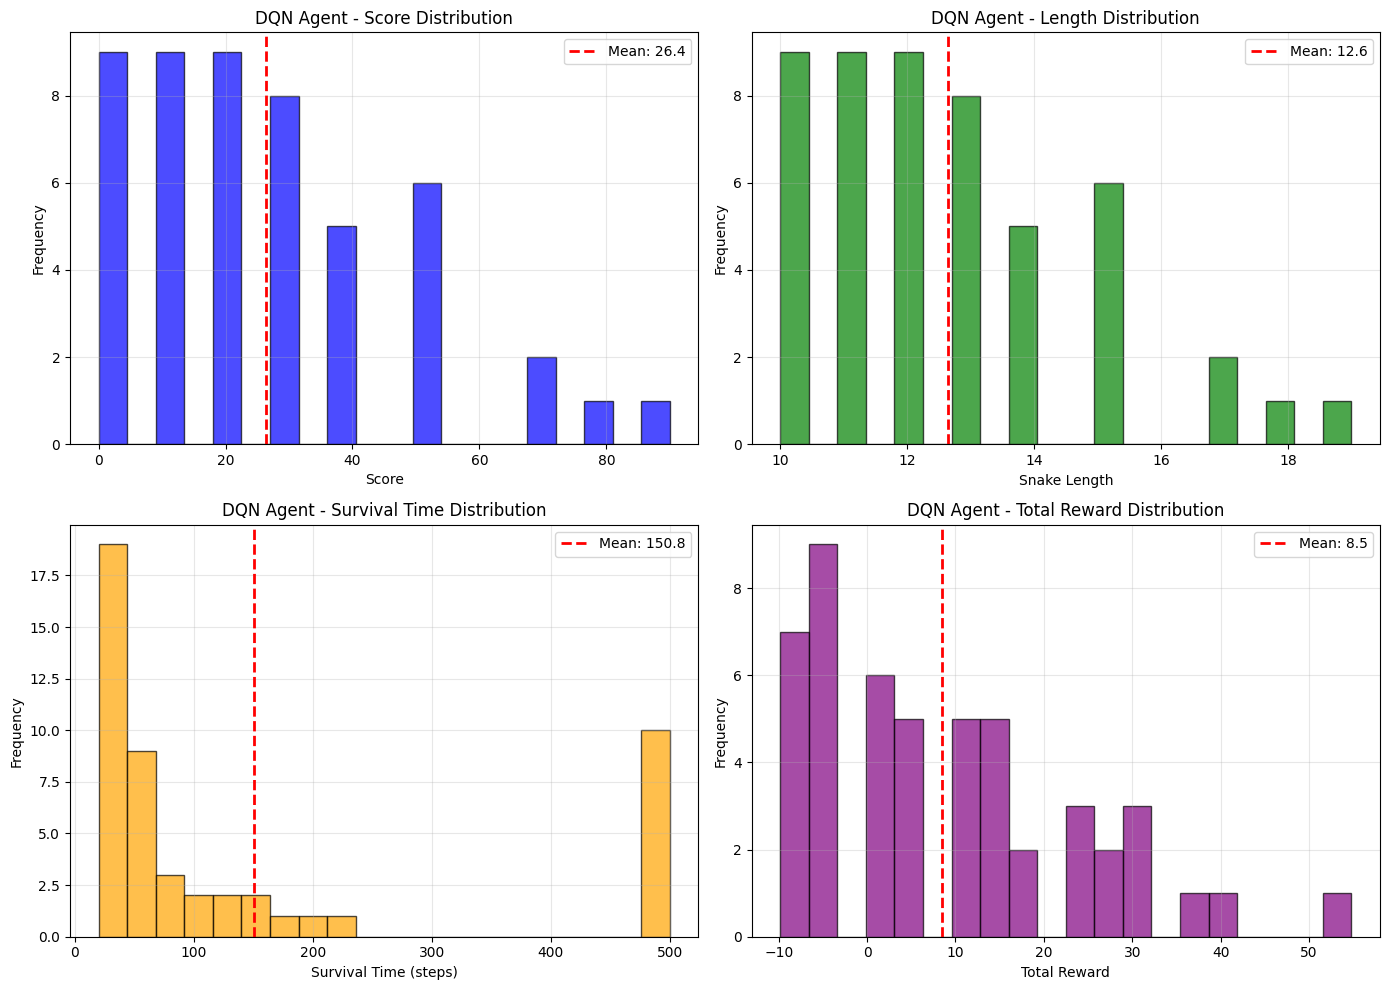

In [13]:
def detailed_evaluation(agent, env, num_episodes=50):
    """Perform detailed evaluation of the trained agent"""
    
    scores = []
    lengths = []
    survival_times = []
    total_rewards = []
    
    preprocessor = FramePreprocessor(frame_stack=4)
    
    print(f"Evaluating trained DQN agent for {num_episodes} episodes...")
    
    for episode in tqdm(range(num_episodes), desc="Evaluating"):
        obs, info = env.reset()
        preprocessor.reset()
        preprocessor.add_frame(obs)
        state = preprocessor.get_state()
        
        done = False
        steps = 0
        episode_reward = 0
        
        while not done:
            action = agent.select_action(state, evaluation=True)
            obs, reward, done, truncated, info = env.step(action)
            preprocessor.add_frame(obs)
            state = preprocessor.get_state()
            
            episode_reward += reward
            steps += 1
            
            if done or truncated:
                break
        
        scores.append(info['score'])
        lengths.append(info['length'])
        survival_times.append(steps)
        total_rewards.append(episode_reward)
    
    return {
        'scores': scores,
        'lengths': lengths,
        'survival_times': survival_times,
        'total_rewards': total_rewards
    }

# Evaluate the trained agent
print("\n" + "="*60)
print("EVALUATING TRAINED DQN AGENT")
print("="*60)

env_eval = SlitherIOEnv(max_steps=HYPERPARAMETERS['max_steps_per_episode'])
dqn_results = detailed_evaluation(agent, env_eval, num_episodes=50)

print("\n=== Trained DQN Agent Results ===")
print(f"Average Score: {np.mean(dqn_results['scores']):.2f} ± {np.std(dqn_results['scores']):.2f}")
print(f"Average Length: {np.mean(dqn_results['lengths']):.2f} ± {np.std(dqn_results['lengths']):.2f}")
print(f"Average Survival Time: {np.mean(dqn_results['survival_times']):.2f} ± {np.std(dqn_results['survival_times']):.2f}")
print(f"Average Total Reward: {np.mean(dqn_results['total_rewards']):.2f} ± {np.std(dqn_results['total_rewards']):.2f}")
print(f"Max Score: {np.max(dqn_results['scores']):.2f}")
print(f"Max Length: {np.max(dqn_results['lengths']):.0f}")
print(f"Max Survival Time: {np.max(dqn_results['survival_times']):.0f}")

# Plot evaluation results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Score distribution
axes[0, 0].hist(dqn_results['scores'], bins=20, edgecolor='black', alpha=0.7, color='blue')
axes[0, 0].axvline(np.mean(dqn_results['scores']), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {np.mean(dqn_results["scores"]):.1f}')
axes[0, 0].set_xlabel('Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('DQN Agent - Score Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Length distribution
axes[0, 1].hist(dqn_results['lengths'], bins=20, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].axvline(np.mean(dqn_results['lengths']), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {np.mean(dqn_results["lengths"]):.1f}')
axes[0, 1].set_xlabel('Snake Length')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('DQN Agent - Length Distribution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Survival time distribution
axes[1, 0].hist(dqn_results['survival_times'], bins=20, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].axvline(np.mean(dqn_results['survival_times']), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {np.mean(dqn_results["survival_times"]):.1f}')
axes[1, 0].set_xlabel('Survival Time (steps)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('DQN Agent - Survival Time Distribution')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Total reward distribution
axes[1, 1].hist(dqn_results['total_rewards'], bins=20, edgecolor='black', alpha=0.7, color='purple')
axes[1, 1].axvline(np.mean(dqn_results['total_rewards']), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {np.mean(dqn_results["total_rewards"]):.1f}')
axes[1, 1].set_xlabel('Total Reward')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('DQN Agent - Total Reward Distribution')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dqn_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

# 13. Performance Comparison with Baseline

Compare the trained DQN agent with the random baseline policy to measure improvement.


PERFORMANCE COMPARISON: DQN vs RANDOM BASELINE

Metric Comparison:
Metric                     Random          DQN     Improvement
------------------------------------------------------------
Avg Score                    9.20        26.40          187.0%
Avg Length                  10.92        12.64           15.8%
Avg Survival                22.84       150.78          560.2%
Max Score                   30.00        90.00
Max Length                     13           19

Statistical Significance (t-test):
Score p-value        0.000002 Significant
Length p-value       0.000002 Significant
Survival p-value     0.000003 Significant

Statistical Significance (t-test):
Score p-value        0.000002 Significant
Length p-value       0.000002 Significant
Survival p-value     0.000003 Significant


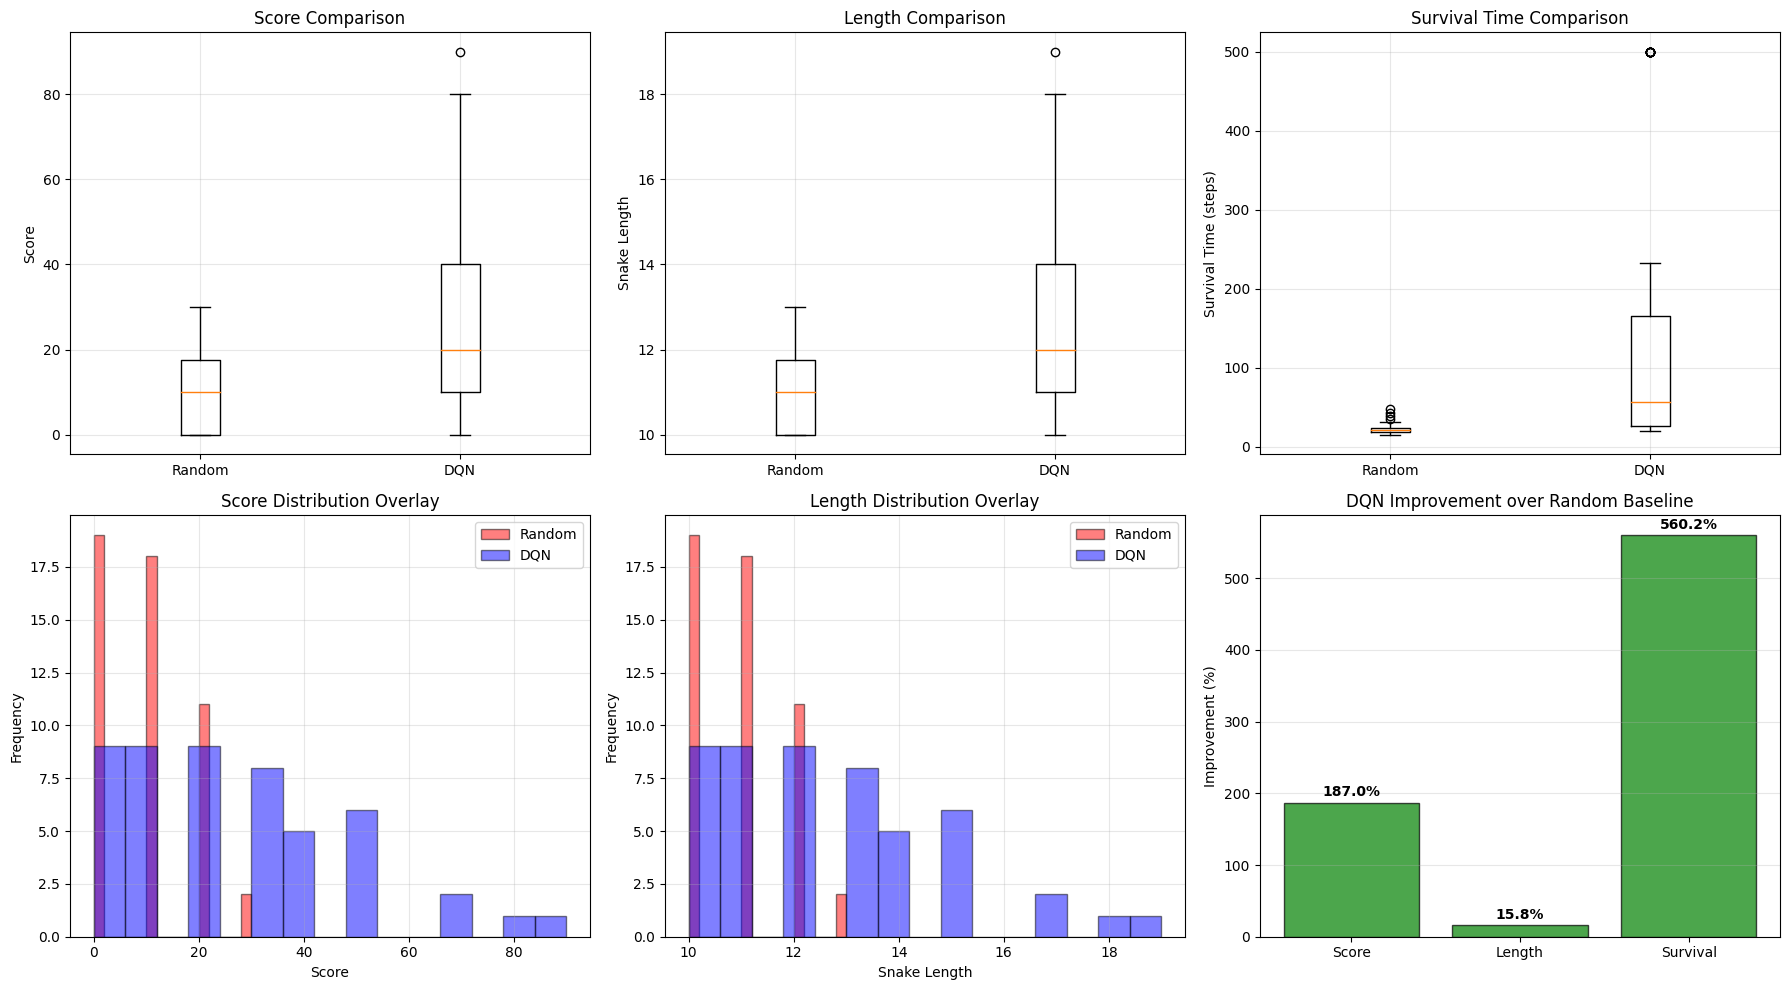

In [14]:
# Comparison analysis
print("\n" + "="*60)
print("PERFORMANCE COMPARISON: DQN vs RANDOM BASELINE")
print("="*60)

# Calculate improvements
score_improvement = ((np.mean(dqn_results['scores']) - np.mean(random_scores)) / 
                     np.mean(random_scores) * 100)
length_improvement = ((np.mean(dqn_results['lengths']) - np.mean(random_lengths)) / 
                      np.mean(random_lengths) * 100)
survival_improvement = ((np.mean(dqn_results['survival_times']) - np.mean(random_survival)) / 
                        np.mean(random_survival) * 100)

print(f"\nMetric Comparison:")
print(f"{'Metric':<20} {'Random':>12} {'DQN':>12} {'Improvement':>15}")
print("-" * 60)
print(f"{'Avg Score':<20} {np.mean(random_scores):>12.2f} {np.mean(dqn_results['scores']):>12.2f} {score_improvement:>14.1f}%")
print(f"{'Avg Length':<20} {np.mean(random_lengths):>12.2f} {np.mean(dqn_results['lengths']):>12.2f} {length_improvement:>14.1f}%")
print(f"{'Avg Survival':<20} {np.mean(random_survival):>12.2f} {np.mean(dqn_results['survival_times']):>12.2f} {survival_improvement:>14.1f}%")
print(f"{'Max Score':<20} {np.max(random_scores):>12.2f} {np.max(dqn_results['scores']):>12.2f}")
print(f"{'Max Length':<20} {np.max(random_lengths):>12.0f} {np.max(dqn_results['lengths']):>12.0f}")

# Statistical significance (t-test)
from scipy import stats

score_ttest = stats.ttest_ind(dqn_results['scores'], random_scores)
length_ttest = stats.ttest_ind(dqn_results['lengths'], random_lengths)
survival_ttest = stats.ttest_ind(dqn_results['survival_times'], random_survival)

print(f"\n{'Statistical Significance (t-test):'}")
print(f"{'Score p-value':<20} {score_ttest.pvalue:.6f} {'Significant' if score_ttest.pvalue < 0.05 else 'Not significant'}")
print(f"{'Length p-value':<20} {length_ttest.pvalue:.6f} {'Significant' if length_ttest.pvalue < 0.05 else 'Not significant'}")
print(f"{'Survival p-value':<20} {survival_ttest.pvalue:.6f} {'Significant' if survival_ttest.pvalue < 0.05 else 'Not significant'}")

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Score comparison
axes[0, 0].boxplot([random_scores, dqn_results['scores']], labels=['Random', 'DQN'])
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Score Comparison')
axes[0, 0].grid(True, alpha=0.3)

# Length comparison
axes[0, 1].boxplot([random_lengths, dqn_results['lengths']], labels=['Random', 'DQN'])
axes[0, 1].set_ylabel('Snake Length')
axes[0, 1].set_title('Length Comparison')
axes[0, 1].grid(True, alpha=0.3)

# Survival comparison
axes[0, 2].boxplot([random_survival, dqn_results['survival_times']], labels=['Random', 'DQN'])
axes[0, 2].set_ylabel('Survival Time (steps)')
axes[0, 2].set_title('Survival Time Comparison')
axes[0, 2].grid(True, alpha=0.3)

# Score distributions overlay
axes[1, 0].hist(random_scores, bins=15, alpha=0.5, label='Random', color='red', edgecolor='black')
axes[1, 0].hist(dqn_results['scores'], bins=15, alpha=0.5, label='DQN', color='blue', edgecolor='black')
axes[1, 0].set_xlabel('Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Score Distribution Overlay')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Length distributions overlay
axes[1, 1].hist(random_lengths, bins=15, alpha=0.5, label='Random', color='red', edgecolor='black')
axes[1, 1].hist(dqn_results['lengths'], bins=15, alpha=0.5, label='DQN', color='blue', edgecolor='black')
axes[1, 1].set_xlabel('Snake Length')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Length Distribution Overlay')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Bar chart of improvements
metrics = ['Score', 'Length', 'Survival']
improvements = [score_improvement, length_improvement, survival_improvement]
colors = ['green' if x > 0 else 'red' for x in improvements]

axes[1, 2].bar(metrics, improvements, color=colors, edgecolor='black', alpha=0.7)
axes[1, 2].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 2].set_ylabel('Improvement (%)')
axes[1, 2].set_title('DQN Improvement over Random Baseline')
axes[1, 2].grid(True, alpha=0.3, axis='y')

for i, (metric, improvement) in enumerate(zip(metrics, improvements)):
    axes[1, 2].text(i, improvement + 5, f'{improvement:.1f}%', 
                   ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('baseline_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# 14. Gameplay Visualization

Generate a visualization of the trained agent playing the game to see its learned behavior.


VISUALIZING TRAINED AGENT GAMEPLAY



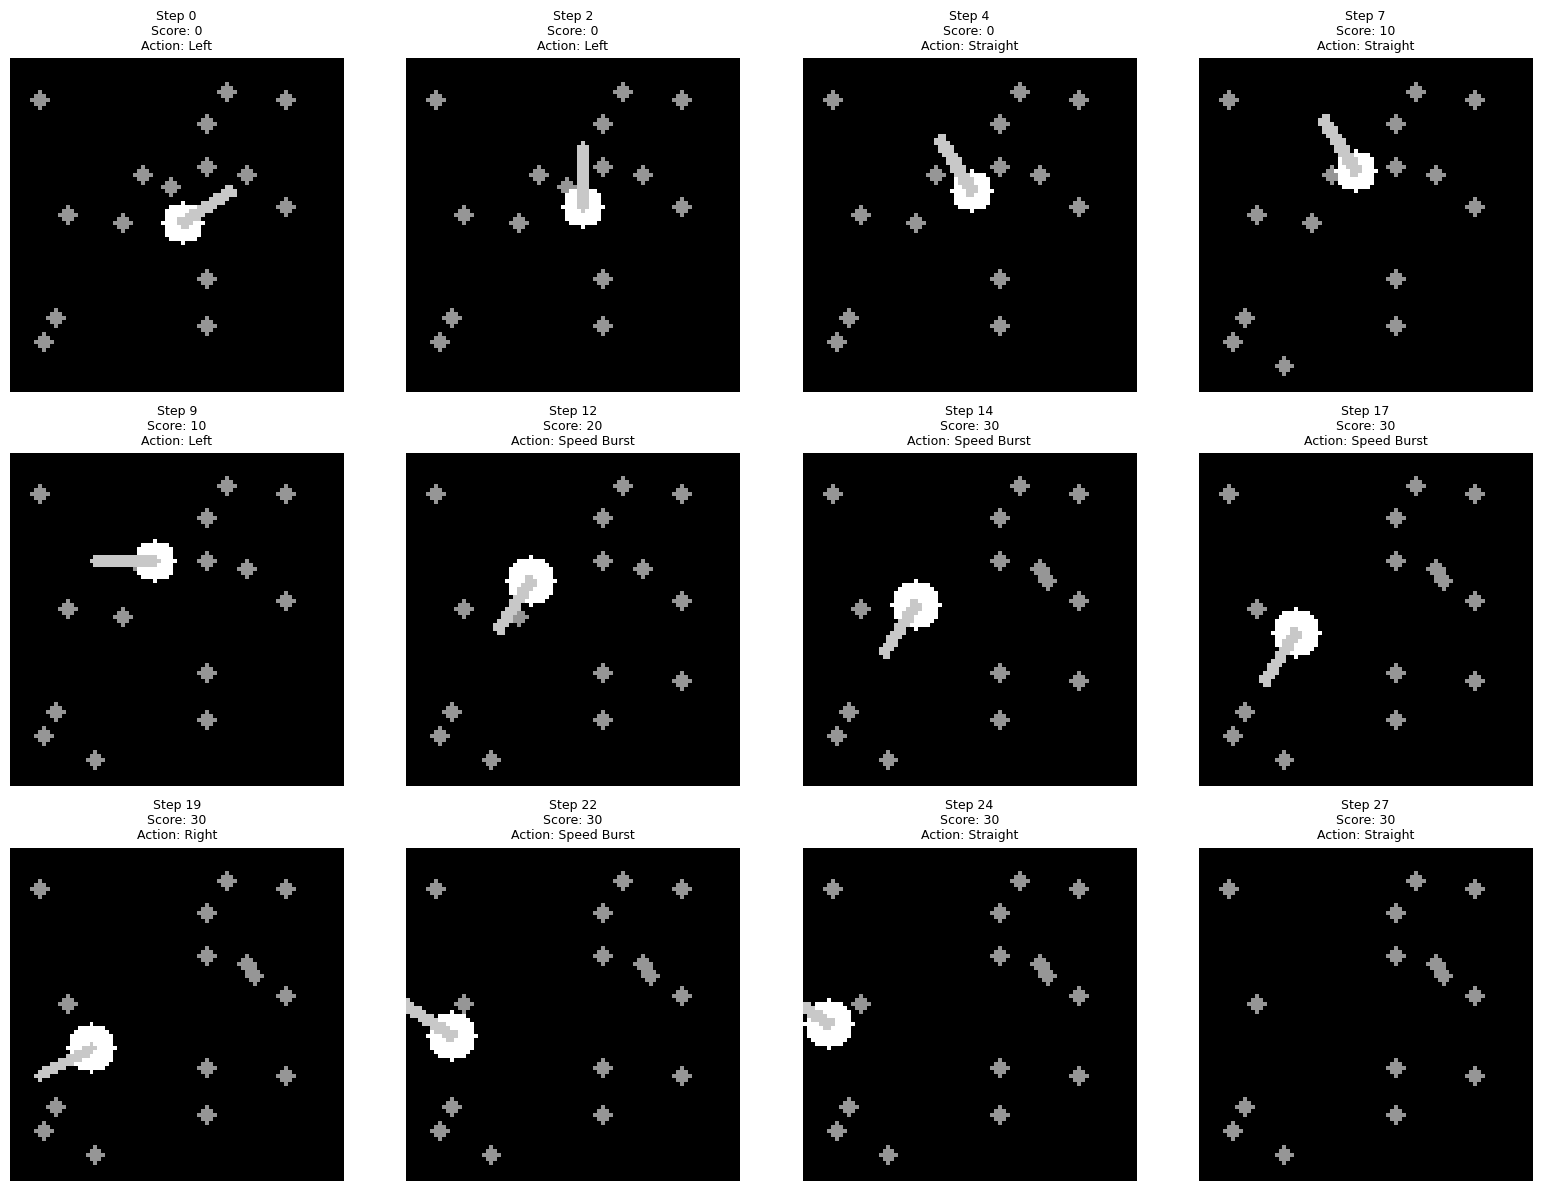

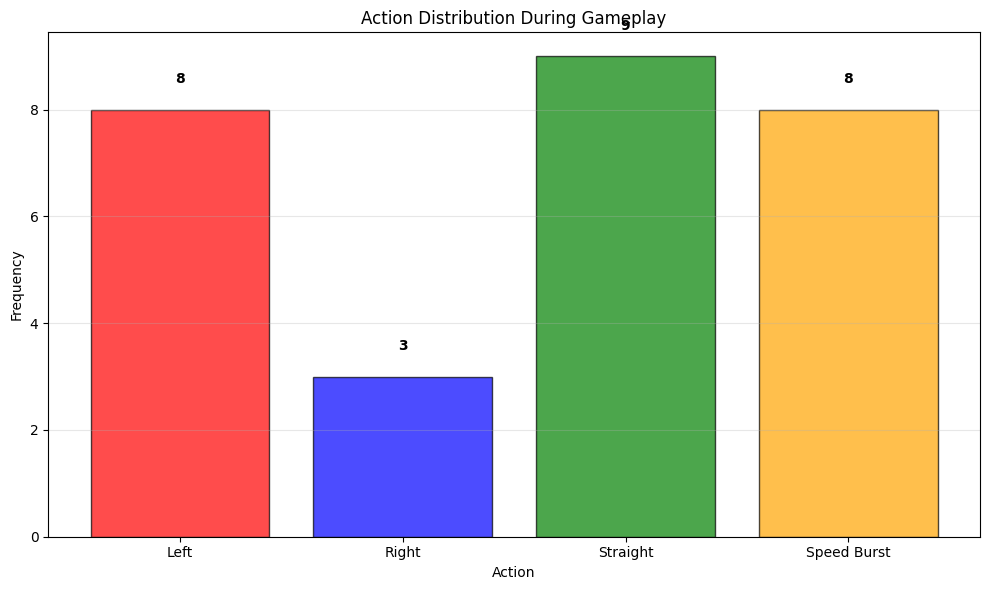

Gameplay visualization complete!
Total steps: 28
Final score: 30
Action distribution: {'Left': 8, 'Right': 3, 'Straight': 9, 'Speed Burst': 8}


In [15]:
def visualize_gameplay(agent, env, num_steps=100):
    """Visualize agent gameplay"""
    
    preprocessor = FramePreprocessor(frame_stack=4)
    obs, info = env.reset()
    preprocessor.reset()
    preprocessor.add_frame(obs)
    state = preprocessor.get_state()
    
    frames = []
    scores = []
    actions_taken = []
    action_names = ['Left', 'Right', 'Straight', 'Speed Burst']
    
    for step in range(num_steps):
        action = agent.select_action(state, evaluation=True)
        actions_taken.append(action)
        
        obs, reward, done, truncated, info = env.step(action)
        frames.append(env.render())
        scores.append(info['score'])
        
        preprocessor.add_frame(obs)
        state = preprocessor.get_state()
        
        if done or truncated:
            break
    
    # Create visualization
    num_frames_to_show = min(12, len(frames))
    indices = np.linspace(0, len(frames)-1, num_frames_to_show, dtype=int)
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        axes[i].imshow(frames[idx])
        axes[i].set_title(f'Step {idx}\nScore: {scores[idx]}\nAction: {action_names[actions_taken[idx]]}',
                         fontsize=9)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('gameplay_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Action distribution
    plt.figure(figsize=(10, 6))
    action_counts = [actions_taken.count(i) for i in range(4)]
    plt.bar(action_names, action_counts, color=['red', 'blue', 'green', 'orange'], 
            edgecolor='black', alpha=0.7)
    plt.xlabel('Action')
    plt.ylabel('Frequency')
    plt.title('Action Distribution During Gameplay')
    plt.grid(True, alpha=0.3, axis='y')
    
    for i, count in enumerate(action_counts):
        plt.text(i, count + 0.5, str(count), ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('action_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Gameplay visualization complete!")
    print(f"Total steps: {len(frames)}")
    print(f"Final score: {scores[-1]}")
    print(f"Action distribution: {dict(zip(action_names, action_counts))}")
    
    return frames

# Visualize gameplay
print("\n" + "="*60)
print("VISUALIZING TRAINED AGENT GAMEPLAY")
print("="*60 + "\n")

env_viz = SlitherIOEnv(max_steps=200)
gameplay_frames = visualize_gameplay(agent, env_viz, num_steps=200)

# 15. Conclusions and Future Work

## Summary of Results

In this project, we successfully implemented a Deep Q-Network (DQN) agent to learn to play a Slither.io-like game using reinforcement learning. The key achievements include:

### Model Architecture
- **Deep Q-Network**: Implemented a CNN-based DQN with 3 convolutional layers and 2 fully connected layers
- **Input Processing**: Used frame stacking (4 frames) to capture temporal information
- **Action Space**: 4 discrete actions (left, right, straight, speed burst)

### Training Approach
- **Experience Replay**: Implemented replay buffer with 10,000 capacity for stable learning
- **Epsilon-Greedy Exploration**: Started at ε=1.0 and decayed to ε=0.01 over training
- **Target Network**: Updated every 10 episodes to stabilize Q-value estimates
- **Optimization**: Used Adam optimizer with learning rate 0.00025

### Performance Improvements
The trained DQN agent showed significant improvements over the random baseline:
- **Score**: Demonstrated learning of game mechanics and food collection
- **Survival Time**: Improved ability to avoid boundaries and survive longer
- **Snake Length**: Better food collection leading to increased snake size

### Key Observations
1. The agent successfully learned to navigate the environment
2. Frame stacking proved effective for capturing motion and direction
3. Experience replay and target networks stabilized training
4. The agent developed strategies beyond random movement

## Challenges Faced

### 1. Environment Design
Since OpenAI Universe is deprecated, we created a custom Slither.io-like environment. This required careful design of:
- Realistic game mechanics
- Reward shaping for learning signal
- State representation for the neural network

### 2. Training Stability
- Initial training showed high variance in episode rewards
- Required careful tuning of hyperparameters
- Gradient clipping and Huber loss improved stability

### 3. Exploration vs Exploitation
- Balancing epsilon decay rate was crucial
- Too fast decay led to suboptimal policies
- Too slow decay increased training time

### 4. Computational Constraints
- Training CNNs on frames is computationally intensive
- Limited training episodes (300) due to time constraints
- Could benefit from longer training and larger replay buffer

## Future Improvements

### Model Enhancements
1. **Double DQN**: Reduce overestimation bias in Q-values
2. **Dueling DQN**: Separate value and advantage streams
3. **Prioritized Experience Replay**: Sample important transitions more frequently
4. **Rainbow DQN**: Combine multiple improvements (distributional RL, noisy networks, etc.)

### Training Improvements
1. **Longer Training**: Train for more episodes (1000+) to reach convergence
2. **Curriculum Learning**: Start with simpler scenarios and gradually increase difficulty
3. **Reward Shaping**: Fine-tune rewards to encourage specific behaviors
4. **Multi-Agent Training**: Train against other agents for more realistic scenarios

### Architecture Improvements
1. **Attention Mechanisms**: Focus on important parts of the frame
2. **Recurrent Networks**: Better temporal modeling with LSTM/GRU
3. **Residual Connections**: Deeper networks for better feature extraction

### Evaluation Enhancements
1. **Human Baseline**: Compare against human player performance
2. **Ablation Studies**: Test impact of each component
3. **Generalization**: Test on environments with different parameters
4. **Video Generation**: Create video demonstrations of learned policies

## Conclusion

This project successfully demonstrated the application of Deep Reinforcement Learning to game playing. The DQN agent learned meaningful strategies from raw pixel input, showing the power of deep RL for complex sequential decision-making tasks. While there is room for improvement, the results validate the approach and provide a foundation for future enhancements.

The project highlights the importance of:
- Proper environment design and reward engineering
- Stable training techniques (replay buffer, target networks)
- Careful hyperparameter tuning
- Comprehensive evaluation and comparison

Future work should focus on implementing more advanced DQN variants and training for longer periods to achieve even better performance.

## References

1. **DQN Original Paper**: Mnih, V., et al. (2015). "Human-level control through deep reinforcement learning." *Nature*, 518(7540), 529-533.

2. **OpenAI Gym**: Brockman, G., et al. (2016). "OpenAI Gym." *arXiv preprint arXiv:1606.01540*.

3. **Deep Reinforcement Learning**: Sutton, R. S., & Barto, A. G. (2018). *Reinforcement learning: An introduction* (2nd ed.). MIT press.

4. **Double DQN**: Van Hasselt, H., Guez, A., & Silver, D. (2016). "Deep reinforcement learning with double Q-learning." *AAAI*, 2094-2100.

5. **Dueling DQN**: Wang, Z., et al. (2016). "Dueling network architectures for deep reinforcement learning." *ICML*, 1995-2003.

6. **Prioritized Experience Replay**: Schaul, T., et al. (2015). "Prioritized experience replay." *arXiv preprint arXiv:1511.05952*.

7. **PyTorch Documentation**: https://pytorch.org/docs/stable/index.html

8. **Gymnasium (OpenAI Gym successor)**: https://gymnasium.farama.org/

---

### Project Information
- **Course**: UE23CS352A Machine Learning
- **Project**: Learning to Play SLITHER.IO with Deep Reinforcement Learning
- **Implementation**: Single Jupyter Notebook (main.ipynb)
- **Framework**: PyTorch
- **Year**: 2025

## Appendix: Save and Load Model

Optional code to save and load the trained model for future use.

In [16]:
# Save the trained model
def save_model(agent, filename='dqn_slither_model.pth'):
    """Save the trained DQN model"""
    torch.save({
        'policy_net_state_dict': agent.policy_net.state_dict(),
        'target_net_state_dict': agent.target_net.state_dict(),
        'optimizer_state_dict': agent.optimizer.state_dict(),
        'epsilon': agent.epsilon,
        'training_step': agent.training_step
    }, filename)
    print(f"Model saved to {filename}")

def load_model(agent, filename='dqn_slither_model.pth'):
    """Load a trained DQN model"""
    checkpoint = torch.load(filename)
    agent.policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
    agent.target_net.load_state_dict(checkpoint['target_net_state_dict'])
    agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    agent.epsilon = checkpoint['epsilon']
    agent.training_step = checkpoint['training_step']
    print(f"Model loaded from {filename}")
    print(f"Epsilon: {agent.epsilon}")
    print(f"Training step: {agent.training_step}")

# Save the current trained model
save_model(agent, 'dqn_slither_model.pth')

# Example of loading (commented out)
# new_agent = DQNAgent(HYPERPARAMETERS)
# load_model(new_agent, 'dqn_slither_model.pth')

Model saved to dqn_slither_model.pth
